
# Imaging Demo

How to create visibility from pixel data and make images.

The example uses ``stixpy`` to obtain STIX pixel data and convert these into visibilities and ``xrayvisim``
to make the images.

Imports


In [1]:
import logging

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective
from sunpy.map import Map, make_fitswcs_header
from sunpy.time import TimeRange
from xrayvision.clean import vis_clean
from xrayvision.imaging import vis_to_image, vis_to_map
from xrayvision.mem import mem, resistant_mean

from stixpy.calibration.visibility import calibrate_visibility, create_meta_pixels, create_visibility
from stixpy.coordinates.frames import STIXImaging
from stixpy.coordinates.transforms import get_hpc_info
from stixpy.imaging.em import em
from stixpy.map.stix import STIXMap  # noqa
from stixpy.product import Product

logger = logging.getLogger(__name__)

c:\Users\Erhan\anaconda3\envs\ip5\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Read science file as Product



In [2]:
cpd_sci = Product(
    "http://pub099.cs.technik.fhnw.ch/fits/L1/2021/09/23/SCI/solo_L1_stix-sci-xray-cpd_20210923T152015-20210923T152639_V02_2109230030-62447.fits"
)
cpd_sci

CompressedPixelData   <sunpy.time.timerange.TimeRange object at 0x2ce22b5dd00>
    Start: 2021-09-23 15:20:15
    End:   2021-09-23 15:26:39
    Center:2021-09-23 15:23:27
    Duration:0.004439814814814813 days or
           0.10655555555555551 hours or
           6.393333333333331 minutes or
           383.59999999999985 seconds
    DetectorMasks
    [0...697]: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

    PixelMasks
    [0...697]: [['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']]

    EnergyEdgeMasks
    [0]: [_,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,_]

Read background file as Product



In [3]:
cpd_bkg = Product(
    "http://pub099.cs.technik.fhnw.ch/fits/L1/2021/09/23/SCI/solo_L1_stix-sci-xray-cpd_20210923T095923-20210923T113523_V02_2109230083-57078.fits"
)
cpd_bkg

CompressedPixelData   <sunpy.time.timerange.TimeRange object at 0x2ce22feb170>
    Start: 2021-09-23 09:59:23
    End:   2021-09-23 11:35:23
    Center:2021-09-23 10:47:23
    Duration:0.06666666666666665 days or
           1.5999999999999996 hours or
           95.99999999999997 minutes or
           5759.999999999999 seconds
    DetectorMasks
    [0]: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

    PixelMasks
    [0]: [['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']]

    EnergyEdgeMasks
    [0]: [_,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]

Set time and energy ranges which will be considered for the science and the background file



In [2]:
time_range_sci = ["2021-09-23T15:20:00", "2021-09-23T15:23:00"]
time_range_bkg = [
    "2021-09-23T09:00:00",
    "2021-09-23T12:00:00",
]  # Set this range larger than the actual observation time
energy_range = [25, 28] * u.keV

Create the meta pixel, A, B, C, D for the science and the background data



In [5]:
meta_pixels_sci = create_meta_pixels(
    cpd_sci, time_range=time_range_sci, energy_range=energy_range, flare_location=[0, 0] * u.arcsec, no_shadowing=True
)

meta_pixels_bkg = create_meta_pixels(
    cpd_bkg, time_range=time_range_bkg, energy_range=energy_range, flare_location=[0, 0] * u.arcsec, no_shadowing=True
)

Perform background subtraction



In [6]:
meta_pixels_bkg_subtracted = {
    **meta_pixels_sci,
    "abcd_rate_kev_cm": meta_pixels_sci["abcd_rate_kev_cm"] - meta_pixels_bkg["abcd_rate_kev_cm"],
    "abcd_rate_error_kev_cm": np.sqrt(
        meta_pixels_sci["abcd_rate_error_kev_cm"] ** 2 + meta_pixels_bkg["abcd_rate_error_kev_cm"] ** 2
    ),
}

Create visibilities from the meta pixels



In [7]:
vis = create_visibility(meta_pixels_bkg_subtracted)

Obtain the necessary ephemeris data create HPC 0,0 coordinate



In [8]:
vis_tr = TimeRange(vis.meta["time_range"])
roll, solo_xyz, pointing = get_hpc_info(vis_tr.start, vis_tr.end)
solo = HeliographicStonyhurst(*solo_xyz, obstime=vis_tr.center, representation_type="cartesian")
center_hpc = SkyCoord(0 * u.deg, 0 * u.deg, frame=Helioprojective(obstime=vis_tr.center, observer=solo))

2025-10-01 14:12:02 - sunpy - WARNING: SunpyDeprecationWarning: pattern has been replaced with the format keyword. This comes with a new syntax and there is a migration guide available at https://docs.sunpy.org/en/latest/topic_guide/scraper_migration.html.
2025-10-01 14:12:02 - sunpy - WARNING: SunpyDeprecationWarning: pattern has been replaced with the format keyword. This comes with a new syntax and there is a migration guide available at https://docs.sunpy.org/en/latest/topic_guide/scraper_migration.html.


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

2025-10-01T14:12:02Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:02 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec


Calibrate the visibilities

If not given will default to sun center flare location



In [9]:
cal_vis = calibrate_visibility(vis, flare_location=center_hpc)

2025-10-01T14:12:03Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:03 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:03 - sunpy - WARNING: SunpyDeprecationWarning: pattern has been replaced with the format keyword. This comes with a new syntax and there is a migration guide available at https://docs.sunpy.org/en/latest/topic_guide/scraper_migration.html.
2025-10-01 14:12:03 - sunpy - WARNING: SunpyDeprecationWarning: pattern has been replaced with the format keyword. This comes with a new syntax and there is a migration guide available at https://docs.sunpy.org/en/latest/topic_guide/scraper_migration.html.


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

2025-10-01T14:12:04Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.63936994 60.12344969]] arcsec
2025-10-01 14:12:04 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.63936994 60.12344969]] arcsec


Selected detectors 10 to 7



In [30]:
# order by sub-collimator e.g. 10a, 10b, 10c, 9a, 9b, 9c ....
isc_10_7 = [3, 20, 22, 16, 14, 32, 21, 26, 4, 24, 8, 28]
idx = np.argwhere(np.isin(cal_vis.meta["isc"], isc_10_7)).ravel()

In [31]:
isc_10_3 = [3, 20, 22, 16, 14, 32, 21, 26, 4, 24, 8, 28, 15, 27, 31, 6, 30, 2, 25, 5, 23, 7, 29, 1]


In [32]:
idx = np.argwhere(np.isin(cal_vis.meta["isc"], isc_10_3)).ravel()

Slice the visibilities to detectors 10 - 7



In [33]:
vis10_7 = cal_vis[idx]

Set up image parameters



In [34]:
imsize = [512, 512] * u.pixel  # number of pixels of the map to reconstruct
pixel = [10, 10] * u.arcsec / u.pixel  # pixel size in arcsec

Make a full disk back projection (inverse transform) map



In [35]:
bp_image = vis_to_image(vis10_7, imsize, pixel_size=pixel)

Obtain the necessary ephemeris data



In [36]:
vis_tr = TimeRange(vis.meta["time_range"])
roll, solo_xyz, pointing = get_hpc_info(vis_tr.start, vis_tr.end)
solo = HeliographicStonyhurst(*solo_xyz, obstime=vis_tr.center, representation_type="cartesian")
coord_stix = center_hpc.transform_to(STIXImaging(obstime=vis_tr.start, obstime_end=vis_tr.end, observer=solo))
header = make_fitswcs_header(
    bp_image, coord_stix, telescope="STIX", observatory="Solar Orbiter", scale=[10, 10] * u.arcsec / u.pix
)
fd_bp_map = Map((bp_image, header))

2025-10-01T14:24:28Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:28 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:24:28Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:28 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec


Convert the coordinates and make a map in Helioprojective and rotate so "North" is "up"
Center of STIX pointing in HPC



In [37]:
header_hp = make_fitswcs_header(
    bp_image, center_hpc, scale=[10, 10] * u.arcsec / u.pix, rotation_angle=90 * u.deg + roll
)
hp_map = Map((bp_image, header_hp))
hp_map_rotated = hp_map.rotate()

Plot the both maps



2025-10-01T14:12:14Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:14 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec


<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

2025-10-01T14:12:14Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:14 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:12:14Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:14 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:12:14Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:14 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:12:14Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:12:14 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:12:14Z INFO stixpy.coordinates.transforms 141: Using SAS point

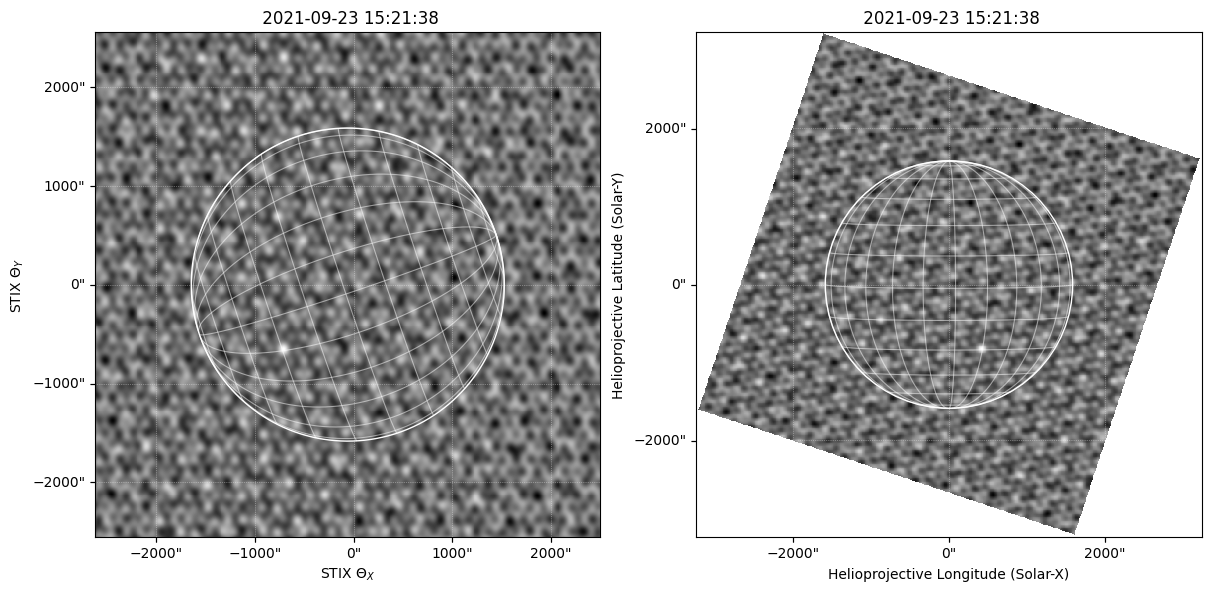

In [16]:
fig = plt.figure(layout="constrained", figsize=(12, 6))
ax = fig.subplot_mosaic(
    [["stix", "hpc"]], per_subplot_kw={"stix": {"projection": fd_bp_map}, "hpc": {"projection": hp_map_rotated}}
)
fd_bp_map.plot(axes=ax["stix"])
fd_bp_map.draw_limb()
fd_bp_map.draw_grid()

hp_map_rotated.plot(axes=ax["hpc"])
hp_map_rotated.draw_limb()
hp_map_rotated.draw_grid()

2025-10-01T14:24:55Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:55 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec


<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

2025-10-01T14:24:56Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:56 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:24:56Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:56 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:24:56Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:56 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:24:56Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:24:56 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:24:56Z INFO stixpy.coordinates.transforms 141: Using SAS point

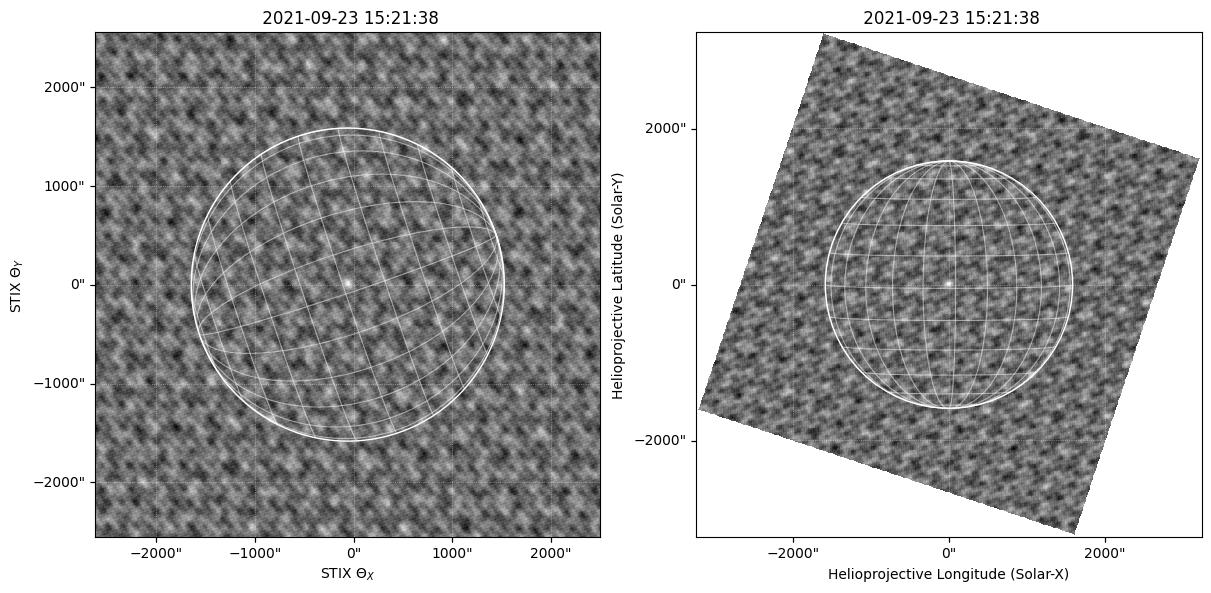

In [38]:
fig = plt.figure(layout="constrained", figsize=(12, 6))
ax = fig.subplot_mosaic(
    [["stix", "hpc"]], per_subplot_kw={"stix": {"projection": fd_bp_map}, "hpc": {"projection": hp_map_rotated}}
)
fd_bp_map.plot(axes=ax["stix"])
fd_bp_map.draw_limb()
fd_bp_map.draw_grid()

hp_map_rotated.plot(axes=ax["hpc"])
hp_map_rotated.draw_limb()
hp_map_rotated.draw_grid()

Estimate the flare location and plot on top of back projection map. Note the coordinates
are automatically converted from the STIXImaging to Helioprojective



In [17]:
max_pixel = np.argwhere(fd_bp_map.data == fd_bp_map.data.max()).ravel() * u.pixel
# because WCS axes and array are reversed
max_stix = fd_bp_map.pixel_to_world(max_pixel[1], max_pixel[0])

ax["stix"].plot_coord(max_stix, marker=".", markersize=50, fillstyle="none", color="r", markeredgewidth=2)
ax["hpc"].plot_coord(max_stix, marker=".", markersize=50, fillstyle="none", color="r", markeredgewidth=2)
fig.tight_layout()

2025-10-01T14:19:20Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:19:20 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:19:20Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:19:20 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:19:20Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:19:20 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:19:20Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:19:20 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:19:20Z INFO stixpy.coordinates.transforms 141: Using SAS point

Use estimated flare location to create more accurate visibilities



In [18]:
meta_pixels_sci = create_meta_pixels(
    cpd_sci, time_range=time_range_sci, energy_range=energy_range, flare_location=max_stix, no_shadowing=True
)

meta_pixels_bkg_subtracted = {
    **meta_pixels_sci,
    "abcd_rate_kev_cm": meta_pixels_sci["abcd_rate_kev_cm"] - meta_pixels_bkg["abcd_rate_kev_cm"],
    "abcd_rate_error_kev_cm": np.sqrt(
        meta_pixels_sci["abcd_rate_error_kev_cm"] ** 2 + meta_pixels_bkg["abcd_rate_error_kev_cm"] ** 2
    ),
}

vis = create_visibility(meta_pixels_bkg_subtracted)
cal_vis = calibrate_visibility(vis, flare_location=max_stix)

2025-10-01T14:19:22Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:19:22 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec


Selected detectors 10 to 3
order by sub-collimator e.g. 10a, 10b, 10c, 9a, 9b, 9c ....



In [19]:
isc_10_3 = [3, 20, 22, 16, 14, 32, 21, 26, 4, 24, 8, 28, 15, 27, 31, 6, 30, 2, 25, 5, 23, 7, 29, 1]
idx = np.argwhere(np.isin(cal_vis.meta["isc"], isc_10_3)).ravel()

Create an ``xrayvsion`` visibility object



In [20]:
cal_vis.meta["offset"] = max_stix
vis10_3 = cal_vis[idx]

Set up image parameters



In [21]:
imsize = [129, 129] * u.pixel  # number of pixels of the map to reconstruct
pixel = [2, 2] * u.arcsec / u.pixel  # pixel size in arcsec

Create a back projection image with natural weighting



In [22]:
bp_nat = vis_to_image(vis10_3, imsize, pixel_size=pixel)

Create a back projection image with uniform weighting



In [23]:
bp_uni = vis_to_image(vis10_3, imsize, pixel_size=pixel, scheme="uniform")

Create a `sunpy.map.Map` with back projection



In [24]:
bp_map = vis_to_map(vis10_3, imsize, pixel_size=pixel)

Crete a clean image using the clean algorithm `vis_clean`



In [25]:
niter = 200  # number of iterations
gain = 0.1  # gain used in each clean iteration
beam_width = 20.0 * u.arcsec
clean_map, model_map, resid_map = vis_clean(
    vis10_3, imsize, pixel_size=pixel, gain=gain, niter=niter, clean_beam_width=20 * u.arcsec
)

2025-10-01T14:19:32Z INFO xrayvision.clean 124: Iter: 0, strength: 1.9311863170342085, location: (np.int64(62), np.int64(66))
2025-10-01 14:19:32 - xrayvision.clean - INFO: Iter: 0, strength: 1.9311863170342085, location: (np.int64(62), np.int64(66))
2025-10-01T14:19:32Z INFO xrayvision.clean 124: Iter: 25, strength: 0.4818291259500767, location: (np.int64(84), np.int64(48))
2025-10-01 14:19:32 - xrayvision.clean - INFO: Iter: 25, strength: 0.4818291259500767, location: (np.int64(84), np.int64(48))
2025-10-01T14:19:32Z INFO xrayvision.clean 145: Largest residual negative
2025-10-01 14:19:32 - xrayvision.clean - INFO: Largest residual negative


Create a sunpy map for the clean image in Helioprojective



In [26]:
header = make_fitswcs_header(
    clean_map.data,
    max_stix.transform_to(Helioprojective(obstime=vis_tr.center, observer=solo)),
    telescope="STIX",
    observatory="Solar Orbiter",
    scale=pixel,
    rotation_angle=90 * u.deg + roll,
)

2025-10-01T14:19:38Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:19:38 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec


Crete a map using the MEM GE algorithm `mem`



In [27]:
snr_value, _ = resistant_mean((np.abs(vis10_3.visibilities) / vis10_3.amplitude_uncertainty).flatten(), 3)
percent_lambda = 2 / (snr_value**2 + 90)
mem_map = mem(vis10_3, shape=imsize, pixel_size=pixel, percent_lambda=percent_lambda)

2025-10-01T14:19:40Z INFO xrayvision.mem 159: Iter: 0, Chi2: 234.36447771830998
2025-10-01 14:19:40 - xrayvision.mem - INFO: Iter: 0, Chi2: 234.36447771830998
2025-10-01T14:19:41Z INFO xrayvision.mem 159: Iter: 25, Chi2: 23.49459412239175
2025-10-01 14:19:41 - xrayvision.mem - INFO: Iter: 25, Chi2: 23.49459412239175
2025-10-01T14:19:41Z INFO xrayvision.mem 159: Iter: 50, Chi2: 18.57628588005375
2025-10-01 14:19:41 - xrayvision.mem - INFO: Iter: 50, Chi2: 18.57628588005375
2025-10-01T14:19:41Z INFO xrayvision.mem 159: Iter: 75, Chi2: 16.518980408643912
2025-10-01 14:19:41 - xrayvision.mem - INFO: Iter: 75, Chi2: 16.518980408643912
2025-10-01T14:19:41Z INFO xrayvision.mem 159: Iter: 100, Chi2: 15.303427427222733
2025-10-01 14:19:41 - xrayvision.mem - INFO: Iter: 100, Chi2: 15.303427427222733
2025-10-01T14:19:41Z INFO xrayvision.mem 159: Iter: 125, Chi2: 14.528204741189672
2025-10-01 14:19:41 - xrayvision.mem - INFO: Iter: 125, Chi2: 14.528204741189672
2025-10-01T14:19:41Z INFO xrayvision

Crete a map using the EM algorithm `EM`



In [28]:
em_map = em(
    meta_pixels_bkg_subtracted["abcd_rate_kev_cm"],
    cal_vis,
    shape=imsize,
    pixel_size=pixel,
    flare_location=max_stix,
    idx=idx,
)


clean_map = Map((clean_map.data, header)).rotate()
bp_map = Map((bp_nat, header)).rotate()
mem_map = Map((mem_map.data, header)).rotate()
em_map = Map((em_map, header)).rotate()

vmax = max([clean_map.data.max(), mem_map.data.max(), em_map.data.max()])

2025-10-01T14:21:00Z INFO stixpy.coordinates.transforms 141: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01 14:21:00 - stixpy.coordinates.transforms - INFO: Using SAS pointing: [[ 3.44543839 59.88232422]] arcsec
2025-10-01T14:21:00Z INFO stixpy.imaging.em 180: Iteration: 25, StdDeV: 0.1393470648812283, C-stat: 0.0851430789028238
2025-10-01 14:21:00 - stixpy.imaging.em - INFO: Iteration: 25, StdDeV: 0.1393470648812283, C-stat: 0.0851430789028238
2025-10-01T14:21:00Z INFO stixpy.imaging.em 180: Iteration: 50, StdDeV: 0.030724933910438325, C-stat: 0.054794487041038786
2025-10-01 14:21:00 - stixpy.imaging.em - INFO: Iteration: 50, StdDeV: 0.030724933910438325, C-stat: 0.054794487041038786
2025-10-01T14:21:00Z INFO stixpy.imaging.em 180: Iteration: 75, StdDeV: 0.005969015698467947, C-stat: 0.0454505439100845
2025-10-01 14:21:00 - stixpy.imaging.em - INFO: Iteration: 75, StdDeV: 0.005969015698467947, C-stat: 0.0454505439100845
2025-10-01T14:21:00Z INFO stixpy.imaging.em 18

Finally compare the images from each algorithm



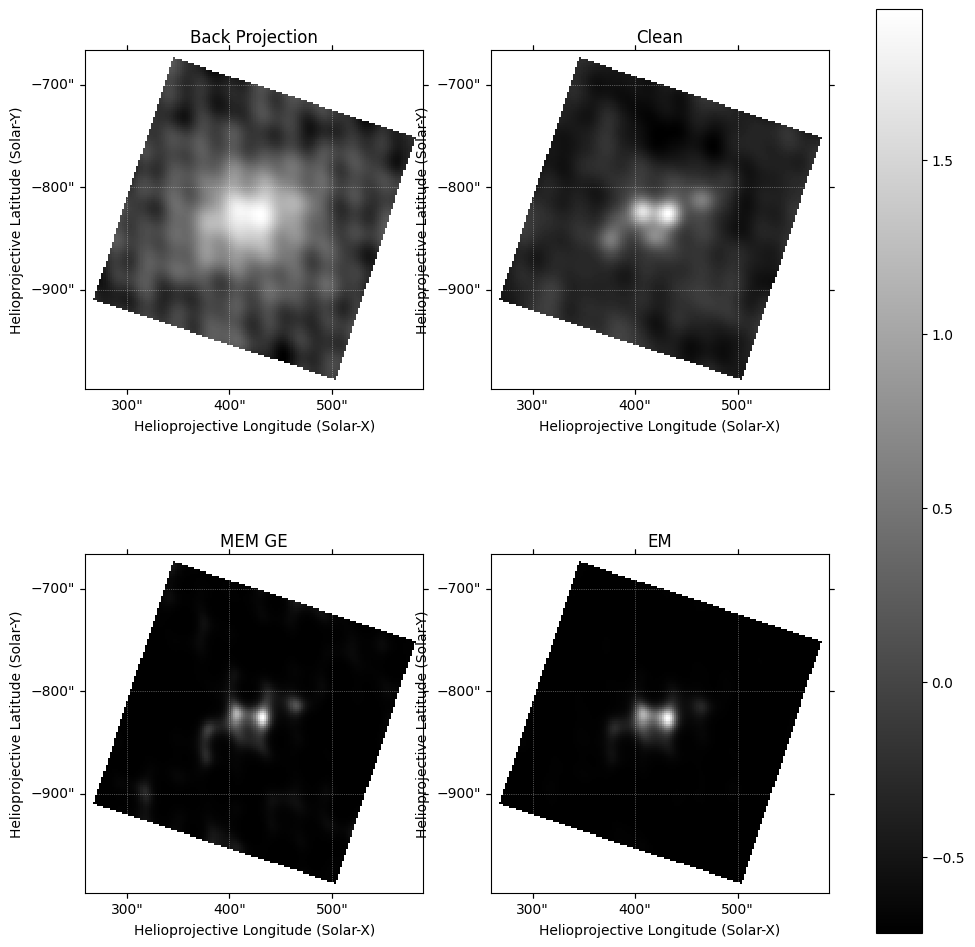

In [29]:
fig = plt.figure(figsize=(12, 12))
ax = fig.subplot_mosaic(
    [
        ["bp", "clean"],
        ["mem", "em"],
    ],
    subplot_kw={"projection": clean_map},
)
a = bp_map.plot(axes=ax["bp"])
ax["bp"].set_title("Back Projection")
b = clean_map.plot(axes=ax["clean"])
ax["clean"].set_title("Clean")
c = mem_map.plot(axes=ax["mem"])
ax["mem"].set_title("MEM GE")
d = em_map.plot(axes=ax["em"])
ax["em"].set_title("EM")
fig.colorbar(a, ax=ax.values())
plt.show()